# Tutorial for processing KOALA data with PyKOALA
# Using PyKOALA KOALA-specific tools
# 2. Obtaining the night calibration

This tutorial provides the information about how to derive the night calibration for KOALA data.

In particular, we will obtain:

1. The throughput correction (2D Throughput, as also flatfield in spectral direction) (T)
2. The small wavelength shift correction (W)
3. The telluric correction (only for red arm) (U)
4. The absolute flux calibration (F)

1-3 are performed in the rss, but we need to reconstruct cubes and combine cubes of calibration stars for accurately getting (4).

All these corrections can be stored in an object **NIGHT_CALIBRATION**.

## Import tasks

In [1]:
# Import modules
# NOTE: All modules needed in this tutorial will be loaded HERE

# General modules
from matplotlib import pyplot as plt
import numpy as np
import warnings
import importlib
# You may want to comment the following line
warnings.filterwarnings("ignore")

# PyKOALA modules
from pykoala import __version__
print("Running pyKOALA version: ", __version__)

from pykoala.instruments.koala_ifu import list_koala_fits_files_in_folder
from pykoala.instruments.koala_ifu import koalaRSS, process_koala_rss, process_n_koala_rss_files
from pykoala.plotting.quick_plot import quick_plot
from pykoala.plotting.rss_plot import rss_image, rss_map, get_spectrum, plot_wavelength

# For Throughput
from pykoala.instruments.koala_ifu import get_throughput_2D

# For small wavelength shifts
from pykoala.corrections.wavelength import WavelengthShiftCorrection
wavelength_shift_using_skylines = WavelengthShiftCorrection.wavelength_shift_using_skylines

# For telluric correction
from pykoala.instruments.koala_ifu import obtain_telluric_correction

# Night Calibration
from pykoala.corrections.night_calibration import NIGHT_CALIBRATION, create_night_calibration
 
from pykoala.ancillary import print_counter 
# This is needed to avoid PyKOALA internal plotting crashing (and need to be loaded last)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

Running pyKOALA version:  0.11.3+70.gbdef4d0.dirty


## Preparing the data

& reading the RSS files already pre-processed with 2dFdr

You can run the cell below for selecting the path to the data, the aaomega arm or grating, and the date, as needed.

In [2]:
aaomega_arms = {'blue': 1, 'red': 2}
aaomega_gratings = {'blue': "580V", 'red': "385R"}


# # Set the date for AAT data files
date="27feb"

# # Choose which arm of the spectrograph is going to be used, it is best starting with the RED grating
arm = 'red'

path_to_data = './data'
# # If using name of the gratings as name of folder
#path_to_filename = f"{path_to_data}/{aaomega_gratings[arm]}"

#The path is modified here because these cell follows the old format for data. This path will be changed in pykoala-tutorials

path_to_filename = "./data"

# # Check the data that we have in folder path_to_filename using task "list_koala_fits_files_in_folder()"

list_koala_fits_files_in_folder(path_to_filename)


> Listing 2dFdr fits files in folder ./data :

  Skyflat          ./data/07sep10011red.fits          5.0 s
                   ./data/07sep10012red.fits          5.0 s
                   ./data/07sep10013red.fits          7.5 s
                   ./data/07sep10014red.fits          9.0 s
  HR7596           ./data/07sep10023red.fits          2.0 s
                   ./data/07sep10024red.fits          2.0 s
                   ./data/07sep10025red.fits          2.0 s
  NGC1311acq       ./data/07sep10060red.fits          60.0 s
  NGC1311          ./data/07sep10061red.fits          1200.0 s
                   ./data/07sep10062red.fits          1200.0 s
  HILT600          ./data/27feb20028red.fits          120.0 s
                   ./data/27feb20029red.fits          120.0 s
                   ./data/27feb20030red.fits          120.0 s
  Tol30            ./data/27feb20031red.fits          1200.0 s
  He2-10           ./data/27feb20032red.fits          1200.0 s
                   ./data/27feb20

# 1. Obtaining the Throughput calibration (T)

The first calibration that we need for ALL our 2dFdr pre-processed RSS files is the Throughput calibration.

For this we need to read a skyflat/domeflat (or a list of them) and obtain the throughput 2D.

This correction is actually TWO:

- The proper Throughput calibration (i.e., scaling all fibres to the same level)
- A flat-fielding in the spectral direction (every wavelength of each fibre at the same level)

We do that running the task **get_throughput_2D()**, also applying a polynomical fit (of order **index_fit_throughput = 11**) to a smoothing spectrum (with **kernel_throughput = 9**) in the spectral direction for properly correcting the flatfielding in that direction.


> Reading a COMBINED skyflat / domeflat to get the 2D throughput...

> Converting KOALA+AAOmega RSS file "./data/combined_skyflat_red.fits" to a koala RSS object...
[Log]  Initialising history log

> Reading RSS file combined_skyflat_red.fits created with None ...

  Number of spectra in this RSS = 1000 ,  number of good spectra = 986  ,  number of bad spectra = 14
  Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[Log]  Initialising history log


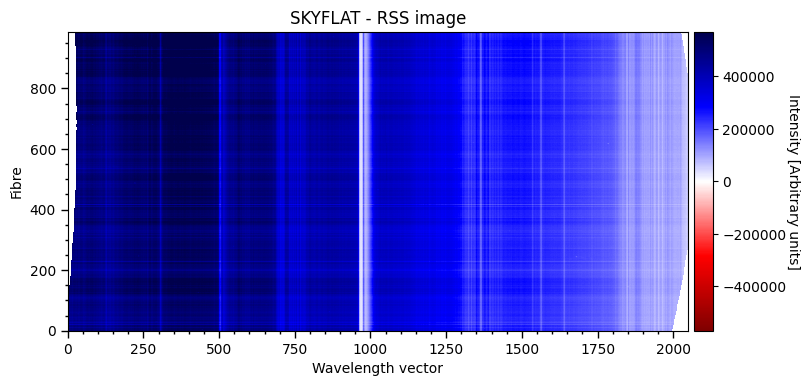

  Found 986 spectra with 2048 wavelengths between 6080.96 and 9305.36 Angstroms.
  This RSS file uses the 385R grating in the red AAOmega arm.
  The KOALA field of view is WIDE: 50.6" x 27.4", with a spaxel size of 1.25" and PA = 89.9º.
  Name of the observation = "SKYFLAT",   Name of this Python RSS object = "skyflat".

> Processing file combined_skyflat_red.fits as requested... 
> Mask included in rss applied to make nan all bad pixels in edges.

> Getting the throughput per wavelength...


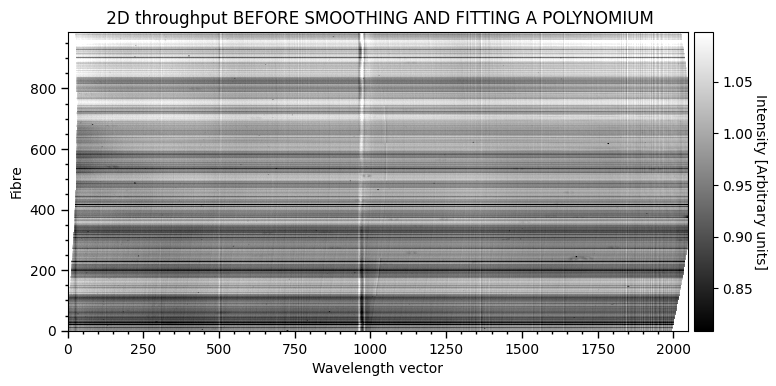


  - Applying smooth with kernel = 9  and using to fit a polynomium of degree = 11 ...
    Process completed!         : 100%|██████████| 986/986 [00:12<00:00, 75.98it/s]
 


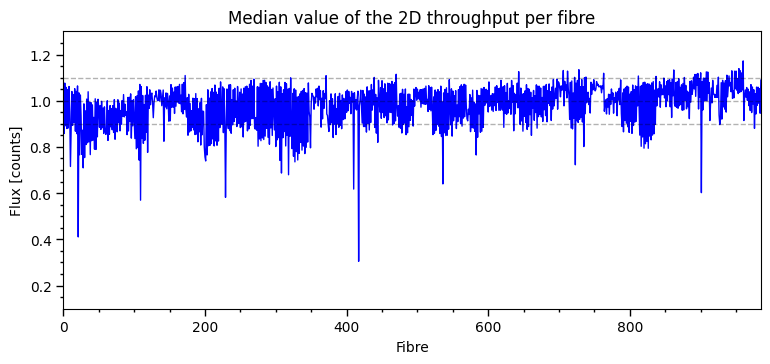

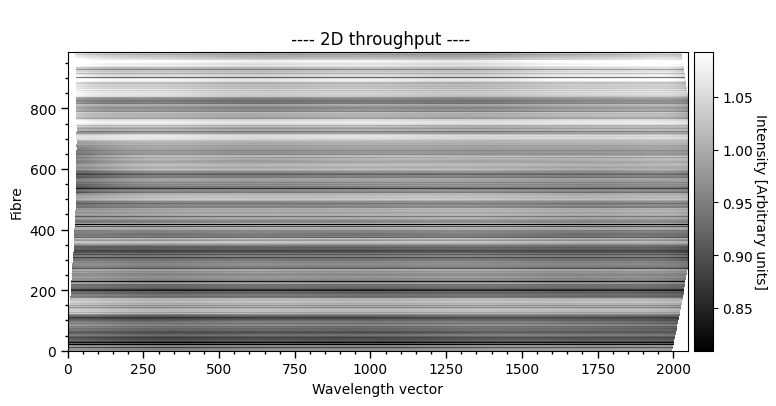

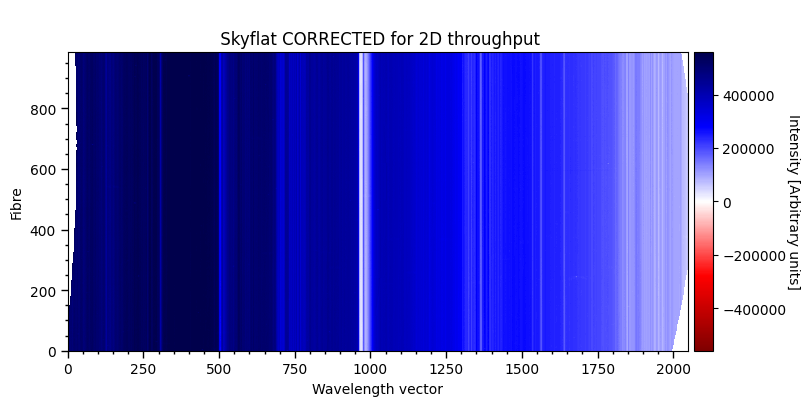

[Throughput] Throughput saved at ./data/throughput_2D_red.fits

> Throughput 2D obtained!


In [3]:
# Provide the name of the flat_rss_file (listed above)
flat_rss_file = 'combined_skyflat_red.fits'
# Provide the name of the throughput_2D_file to be SAVED (if full path is not here, it will use path in parameter path)
throughput_2D_file = "throughput_2D_red.fits"

throughput_2D_red = get_throughput_2D(file_skyflat = flat_rss_file,           # .fits file with skyflat/domeflat
                                      path = path_to_filename,                # path to this file (optional)
                                      #rss_object_name = "skyflat_red",       # Name of the object to be created (optional)
                                      #rss = skyflat_red,                     # RSS to be used for obtaining throughput_2D_red, if obtained
                                      throughput_2D_file=throughput_2D_file, # If given, the .fits file with the throughput is saved in this file (in path)

                                      # These are the optional parameters and their default values:
                                      correct_ccd_defects = False,            # Correct ccd_defects after reading rss (not needed if smoothing, 
                                                                              # default is False if smoothing and True if not smoothing)
                                      kernel_throughput = 9,                  # Kernel (odd number) for smoothing in spectral direction (default is None, no smoothing)
                                      index_fit_throughput = 11,              # Order of the polynomiun to fit to smooth spectrum (default is 11)
                                      also_return_skyflat = False,            # If True, the task also returns the skyflat object (default is True)
                                      plot_final_rss = False,                 # Plot the image of resulting rss (default is False)

                                      # Commun verbose / plotting parameters in **kwargs
                                      verbose= True,                          # Print what it is doing (default is False)
                                      verbose_counter = True,                 # This provides info about % processing (default is as verbose)
                                      warnings=True,                          # Print warnings (default is False)
                                      plot=True)                              # Plot the plots (default is False)

The obtained Throughput 2D is a **CORRECTION OBJECT**.

As we can see, the 2D throughput BEFORE smoothing and fitting a polynomium keeps atmospheric features and artefacts coming from the issue of the (small) wavelength shift problem of RSS provided by 2dFdr. 

The obtained 2D throughput is what we seek: it includes the **fibre-by-fibre throughput offset** (also seen in plot *"Median value of the 2D throughput per fibre"* above) AND the **flatfielding in the spectral direction** (this is relatively small but important).

In [4]:
# # We can also save the Throughput 2D in throughput_2D_file using:
# # NOTE: throughput_2D_file has to have the FULL path (TO BE FIXED in PyKOALA update)

# throughput.tofits(throughput_2D_file)

In [5]:
# # Read the Throughput 2D from throughput_2D_file:
# # NOTE: throughput_2D_file has to have the FULL path (TO BE FIXED in PyKOALA update)

# throughput_2D_red  = Throughput(path=throughput_2D_file)

# Obtaining the (small) wavelength shift correction

2dFdr is currently not providing a perfect wavelength calibration in all wavelengths. There is a drift from the first to the last fibre that is typically of the order of the wavelength resolution (or a bit less), ~1 A for the low-resolution gratings.

However, correcting this is CRITICAL not only for science but for getting a proper SKY SUBSTRACTION.

We find the correction reading a rss with a STAR, identifying telluric emission/absorption features near the extremes of the wavelength range (there is also a small drift with wavelength, this should be included in a future update but it is not critical for sky substraction), fitting Gaussians to find their centroid, and then fit a 1 or 2 order polynomical fit in the wavelength direction for finding the wavelength shift correction.

We use **process_koala_rss()** task for correcting the star rss for throughput and ccd_defects, and then task **WavelengthShiftCorrection.wavelength_shift_using_skylines()** for finding the wavelength shift correction. This task also performs some clipping of the outliers and median of several adjacent wavelenghts. The emission/absorption skylines can be selected or just use all bright ones in valid wavelength range.


> Converting KOALA+AAOmega RSS file "./data/27feb20028red.fits" to a koala RSS object...
[Log]  Initialising history log

> Reading RSS file 27feb20028red.fits created with None ...

  Number of spectra in this RSS = 1000 ,  number of good spectra = 986  ,  number of bad spectra = 14
  Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[Log]  Initialising history log


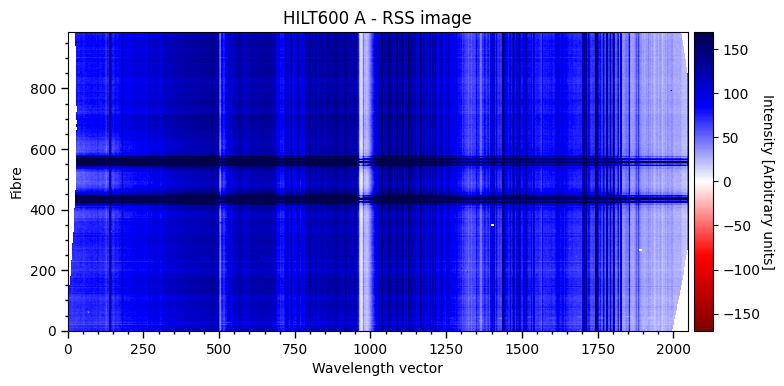

  Found 986 spectra with 2048 wavelengths between 6080.96 and 9305.36 Angstroms.
  This RSS file uses the 385R grating in the red AAOmega arm.
  The KOALA field of view is WIDE: 50.6" x 27.4", with a spaxel size of 1.25" and PA = 89.9º.
  Name of the observation = "HILT600 A",   Name of this Python RSS object = "star1_red".

> Processing file 27feb20028red.fits as requested... 


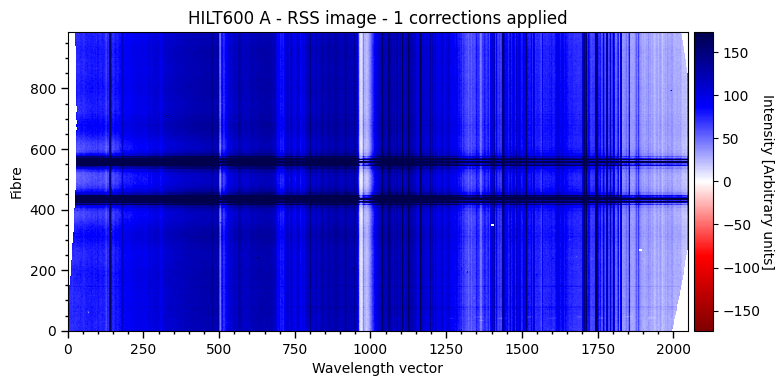


> Summary of processing rss file "27feb20028red.fits" :
  Name of the observation = "HILT600 A",   Name of this Python RSS object = "star1_red".
  Corrections applied: 1 in total:
  - apply_throughput

  All applied corrections are stored in star1_red.intensity !


In [6]:
star_rss_file = '27feb20028red.fits' 
wavelength_shift_correction_file = "wavelength_shift_correction_red.fits"

star1_red = process_koala_rss(rss_object_name="star1_red", 
                              path = path_to_filename,
                              filename=star_rss_file, 
                              apply_throughput = True, 
                              throughput=throughput_2D_red,
                              correct_ccd_defects = False,          # This can be False if using median_fibres below.
                              plot_final_rss= True, 
                              plot = True, 
                              verbose = True)

Now, we run the task **wavelength_shift_using_skylines()**, which is located in **WavelengthShiftCorrection()**.


> Computing small wavelength shifts using skylines...
  Checking the values of skylines provided in the file
  /home/mbolivar/pykoala/src/pykoala/corrections/../input_data/sky_lines/sky_lines_rest.dat
  ---------------------------------------------------------------------
      Center   fnl  lowlow lowhigh    highlow highhigh      xmin   xmax
     5577.338   0     40.0   15.0        15.0    40.0      5500.0 5650.0
     6300.309   0    150.0   80.0        80.0   150.0      6100.0 6500.0
     6363.783   0    260.0  150.0        35.0    80.0      6100.0 6500.0
     7340.901   0    220.0  120.0       240.0   350.0      7100.0 7700.0
     8430.147   0    260.0  160.0       275.0   315.0      8110.0 8760.0
     8465.374   0    290.0  190.0       245.0   285.0      8110.0 8760.0
     8504.780   0    325.0  225.0       205.0   245.0      8110.0 8760.0
     8919.637   0    215.0  170.0        50.0   250.0      8700.0 9200.0
     8958.103   0    255.0  210.0        50.0   250.0      8700.0 9200

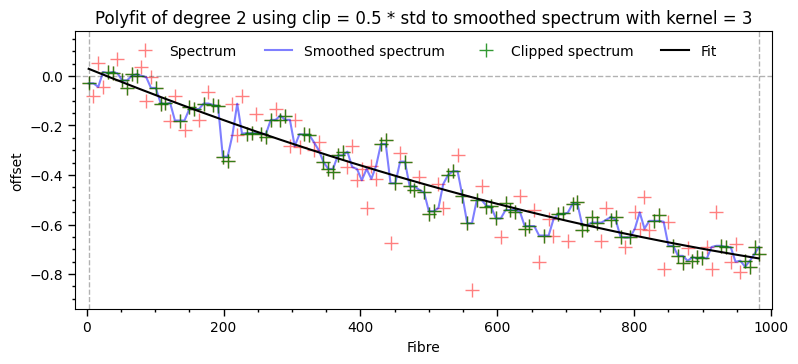

  - Checking fit in skyline 8430.147 :

> Fitting a polynomium of degree 2 using clip = 0.5 * std to smoothed spectrum with kernel =  3 ...
  Eliminated 31 outliers, the solution is:  [ 1.70859197e-07 -9.50151897e-04  5.20917920e-02]


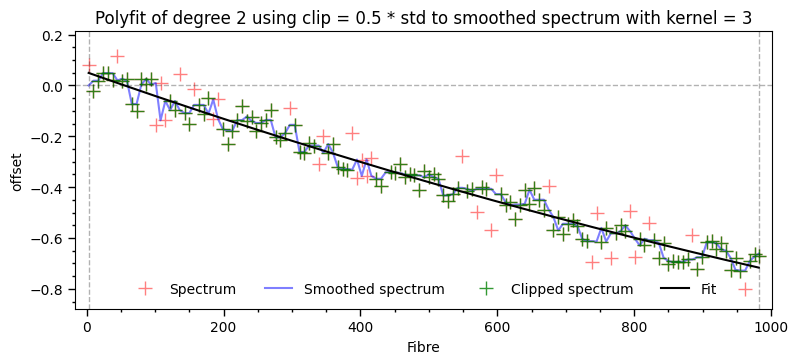

  - Checking fit in skyline 8465.374 :

> Fitting a polynomium of degree 2 using clip = 0.5 * std to smoothed spectrum with kernel =  3 ...
  Eliminated 19 outliers, the solution is:  [ 2.29751206e-07 -1.04538659e-03  4.24009201e-02]


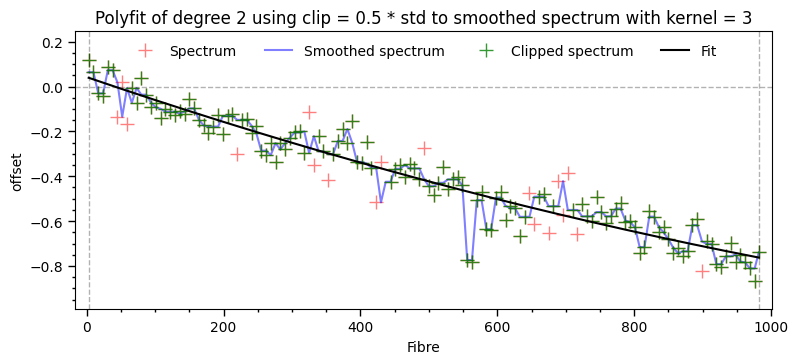

  - Checking combined fits:

> Fitting a polynomium of degree 2 using clip = 1.0 * std to smoothed spectrum with kernel =  3 ...
  Eliminated 34 outliers, the solution is:  [ 2.27602201e-07 -1.01223909e-03  3.49621076e-02]


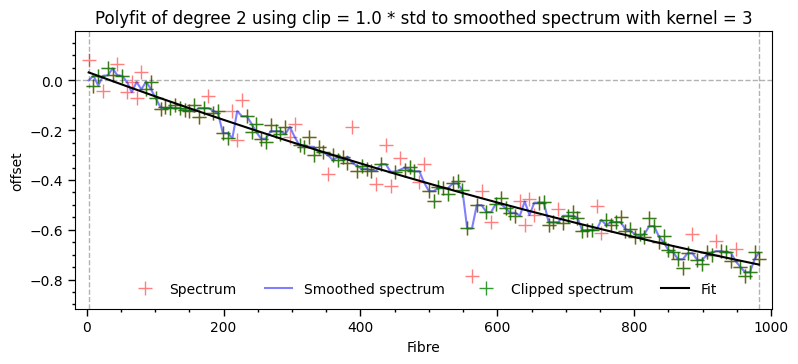


> Median of solutions to the second-order polynomy a0x +  a1x * fibre + a2x * fibre**2 to all fibres (GREEN):
  [0.04240092007478291, -0.0010453865917248429, 2.297512062531483e-07]
  offset_min = -0.764 A ,  offset_max = 0.042 A,  offset_difference = 0.807 A

> Fitting a second-order polynomy a0x +  a1x * fibre + a2x * fibre**2 to the median offset per skyline (BLUE):
  [0.034962107611044686, -0.0010122390892365555, 2.2760220092134824e-07]
  offset_min = -0.741 A ,  offset_max = 0.035 A,  offset_difference = 0.776 A


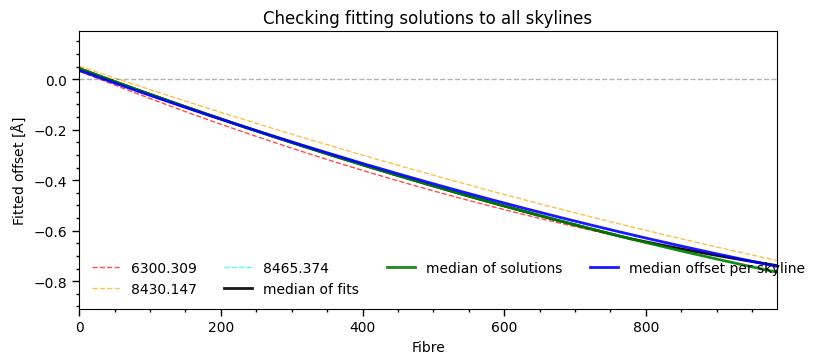

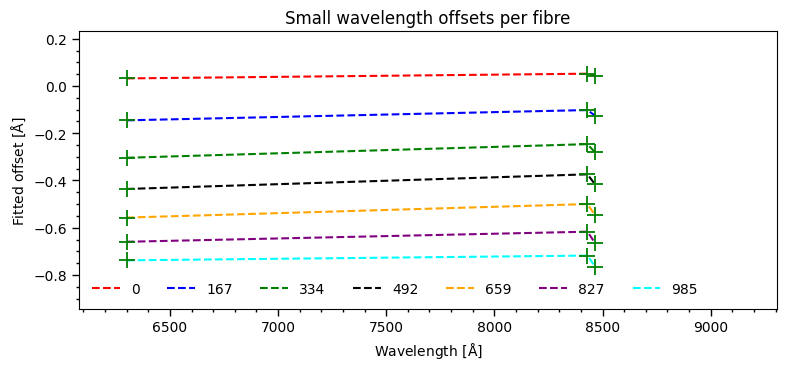


> Small wavelength offsets for selected fibres considering the 3 skylines:
  --------------------------------------------------
  Fibre        Min     Med    Max      std      disp   (all in A)
      0      0.032   0.042  0.052    0.008     0.020
    167     -0.145  -0.126 -0.102    0.018     0.044
    334     -0.304  -0.281 -0.246    0.024     0.058
    492     -0.436  -0.416 -0.374    0.026     0.062
    659     -0.557  -0.547 -0.500    0.025     0.057
    827     -0.665  -0.660 -0.617    0.022     0.048
    985     -0.764  -0.738 -0.718    0.019     0.046
  --------------------------------------------------

> Computing small wavelength shifts using skylines COMPLETED and saved in a WavelengthShiftCorrection object!
[WavelengthShiftCorrection] WavelengthShiftCorrection saved at ./data/wavelength_shift_correction_red.fits


In [7]:
wavelength_shift_correction_red = wavelength_shift_using_skylines(star1_red,                              # rss of the star to use
                                                                  wavelength_shift_correction_file = wavelength_shift_correction_file,   # wavelength_shift_correction_file to be saved                       
                                                                  path = path_to_filename,                # path to file and where wavelength_shift_correction_file will be saved (if its full path not given)

                                                                  # These are the optional parameters and their default values:
                                                                  #median_fibres = 7,                     # Do the Gaussian fitting promediating 7 adjacent wavelengths (optional, recommended)
                                                                  #show_fibres = None,                    # Show corrections in these fibres. If None it shows the first one, the middle one, and the last one if plot=True
                                                                  #sky_lines = [6300.309, 8430.147],      # Use these skylines for Gaussian fitting 
                                                                                                          # (optional, default 3 lines for each AAOmega grating,
                                                                                                          # Use "all" for all bright skylines in the valid wavelength range)
                                                                  #index_fit = 2,                         # Degree of the polynomiun to be used for fitting shift vs wavelength. Default is 2
                                                                  #kernel_fit= None,                      # Smoothing of the Gaussian fit results for fitting shift vs wavelength.  
                                                                                                          # If median_fibres is not None, default is 3, if median_fibres is not given, default is 19
                                                                  #clip_fit = 0.5,                        # Clipping values for the fitting shift vs wavelength. Default is 0.5 
                                                                  
                                                                  # Commun verbose / plotting parameters
                                                                  verbose= True,                          # Print what it is doing (default is False)
                                                                  #verbose_counter = True,                # This provides info about % processing (default is as verbose)
                                                                  warnings=True,                          # Print warnings (default is False)
                                                                  plot=True)                              # Plot the plots (default is False)

In [8]:
# # Saving wavelength_shift_correction_red:
# wavelength_shift_correction_red.tofits("wavelength_shift_correction_red.fits", path_to_filename)

In [9]:
# # Reading wavelength_shift_correction_red from fits files:
#wavelength_shift_correction_red = WavelengthShiftCorrection(fits_file="wavelength_shift_correction_red.fits",  
#                                                            path_to_file=path_to_filename)

# Obtaining the Telluric correction

We can use 1 or many rss files with calibration stars (ideally, telluric stars, but at least being sure these stars do not have important absorption lines) using the task **obtain_telluric_correction()**. 

First, we have to be sure that the RSS files of the stars have been corrected for:
1. Throughput
2. ccd_defects
3. wavelenght shifts
4. extinction



> Processing rss 1 of 3 :    ---------------------------------------------

> Converting KOALA+AAOmega RSS file "./data/27feb20028red.fits" to a koala RSS object...
[Log]  Initialising history log

> Reading RSS file 27feb20028red.fits created with None ...

  Number of spectra in this RSS = 1000 ,  number of good spectra = 986  ,  number of bad spectra = 14
  Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[Log]  Initialising history log
  Found 986 spectra with 2048 wavelengths between 6080.96 and 9305.36 Angstroms.
  This RSS file uses the 385R grating in the red AAOmega arm.
  The KOALA field of view is WIDE: 50.6" x 27.4", with a spaxel size of 1.25" and PA = 89.9º.
  Name of the observation = "HILT600 A",   Name of this Python RSS object = "star1_red".

> Processing file 27feb20028red.fits as requested... 
> Applying nearest neighbour interpolation to remove NaN values ...
> Applying wavelength shift solution to all fibres in object using medi

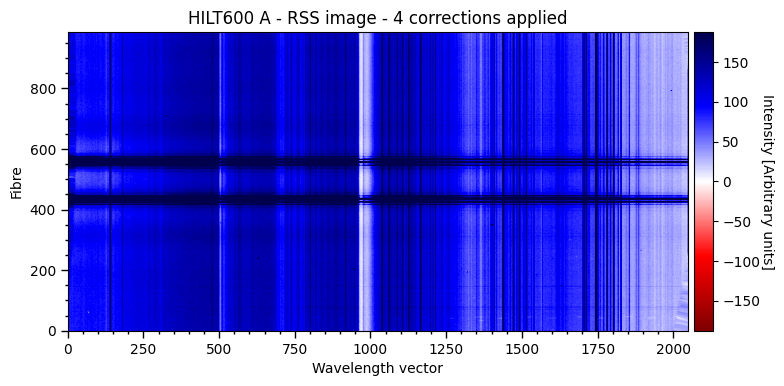


> Summary of processing rss file "27feb20028red.fits" :
  Name of the observation = "HILT600 A",   Name of this Python RSS object = "star1_red".
  Corrections applied: 4 in total:
  - apply_throughput
  - correct_ccd_defects
  - wavelength_shift_correction
  - extinction_correction

  All applied corrections are stored in star1_red.intensity !

> Processing rss 2 of 3 :    ---------------------------------------------

> Converting KOALA+AAOmega RSS file "./data/27feb20029red.fits" to a koala RSS object...
[Log]  Initialising history log

> Reading RSS file 27feb20029red.fits created with None ...

  Number of spectra in this RSS = 1000 ,  number of good spectra = 986  ,  number of bad spectra = 14
  Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[Log]  Initialising history log
  Found 986 spectra with 2048 wavelengths between 6080.96 and 9305.36 Angstroms.
  This RSS file uses the 385R grating in the red AAOmega arm.
  The KOALA field of view is W

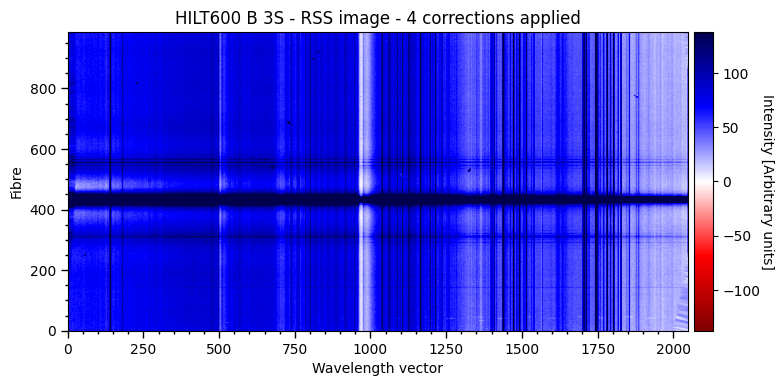


> Summary of processing rss file "27feb20029red.fits" :
  Name of the observation = "HILT600 B 3S",   Name of this Python RSS object = "star2_red".
  Corrections applied: 4 in total:
  - apply_throughput
  - correct_ccd_defects
  - wavelength_shift_correction
  - extinction_correction

  All applied corrections are stored in star2_red.intensity !

> Processing rss 3 of 3 :    ---------------------------------------------

> Converting KOALA+AAOmega RSS file "./data/27feb20030red.fits" to a koala RSS object...
[Log]  Initialising history log

> Reading RSS file 27feb20030red.fits created with None ...

  Number of spectra in this RSS = 1000 ,  number of good spectra = 986  ,  number of bad spectra = 14
  Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[Log]  Initialising history log
  Found 986 spectra with 2048 wavelengths between 6080.96 and 9305.36 Angstroms.
  This RSS file uses the 385R grating in the red AAOmega arm.
  The KOALA field of view i

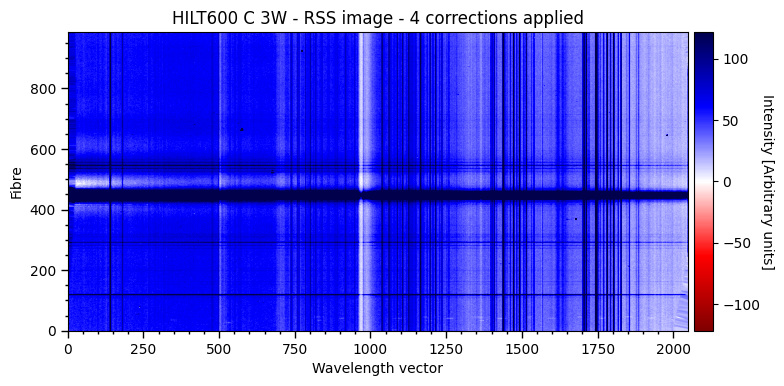


> Summary of processing rss file "27feb20030red.fits" :
  Name of the observation = "HILT600 C 3W",   Name of this Python RSS object = "star3_red".
  Corrections applied: 4 in total:
  - apply_throughput
  - correct_ccd_defects
  - wavelength_shift_correction
  - extinction_correction

  All applied corrections are stored in star3_red.intensity !


In [10]:
star_rss_files = ["27feb20028red.fits", "27feb20029red.fits", "27feb20030red.fits"]
rss_object_name_list = ["star1_red", "star2_red", "star3_red"]

star1_red, star2_red, star3_red = process_n_koala_rss_files(filename_list = star_rss_files,                 # List with the name of fits files
                                                            path = path_to_filename,                        # Path to fits files (optional)
                                                            rss_object_name_list = rss_object_name_list,    # List with the names of the rss objects to be created (optional)
                                                            apply_throughput = True,                        # (T) Apply the throughout correction
                                                            throughput=throughput_2D_red,                   # Throughput object
                                                            correct_ccd_defects = True,                     # (C) Correct for CCD defects
                                                            fix_wavelengths = True,                         # (W) Correct for small wavelength shifts
                                                            wavelength_shift_correction = wavelength_shift_correction_red, # Wavelength shift correction object
                                                            correct_for_extinction = True,                  # (X) Correct for extincion
                                                            plot_final_rss= True,                           # Plot final rss
                                                            plot = False,                                   # No plotting anything else, for making this step easier to see 
                                                            verbose = True)                                 # Print what it is doing


> Obtaining telluric correction using 3 stars...
Star 1 : HILT600 A
[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Estimating telluric correction using input observation
Star 2 : HILT600 B 3S
[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Estimating telluric correction using input observation
Star 3 : HILT600 C 3W
[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Estimating telluric correction using input observation
[Correction: TelluricCorretion] Saving telluric correction into file ./data/telluric_correction.dat


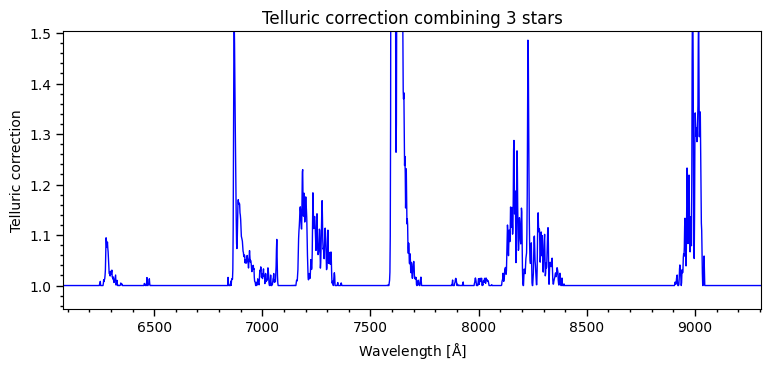

In [11]:
# Create a list with star rss
star_list = [star1_red, star2_red, star3_red]    

# Provide the name of the file where the telluric correction will be saved
telluric_correction_file = "telluric_correction.dat" 

# Run obtain_telluric_correction()
telluric_correction = obtain_telluric_correction(star_list = star_list,                                  # List with the rss/cubes objects for stars
                                                 telluric_correction_file = telluric_correction_file,   # if given, the correction is saved in this file
                                                 path_to_data = path_to_filename,                       # Path where the correction will be saved if requested
                                                 #width_for_telluric = 30,                               # Width for telluric
                                                 verbose = True,                                         # Print what it is doing
                                                 plot=True)                                              # Plot the corrections

# Prepare the calibration of the night

The calibration of the night includes 4 calibrations:

1. Throughput 2D correction
2. Small wavelength shifts correction
3. Telluric correction (only for red data)
4. Absolute flux calibration

We have already obtained 1, 2, and 3. For getting the best absolute flux calibration we need combine and process the stars cubes (we'll do it later), but we can start preparing the calibration of the night using the OBJECT **NIGHT_CALIBRATION**.

We run task **create_night_calibration()** for this:

In [12]:
calibration_night_385R = create_night_calibration(throughput = throughput_2D_red,                                # (T) Throughput correction object or file
                                                  wavelength_shift_correction = wavelength_shift_correction_red, # (W) Small wavelength shift correction object or file
                                                  telluric_correction = telluric_correction,                     # (U) Telluric correction object or file
                                                  #flux_calibration = None,                                      # (F) Flux calibration object or file

                                                  #path = None,                      # (optional) Path to the calibration files, if needed
                                                  data_container = star1_red,        # (optional) rss object of star (for taking date, grating, wavelength if small wavelength shift correction is not provided)
                                                  #date = None,                      # (optional) date of the observations
                                                  #grating = None,                   # (optional) grating used
                                                  #wavelength = None,                # (optional) wavelength vector
                                                  #star_list = None,                 # (optional) These are stars object with the info of calibration stars
                                                
                                                  verbose = True)                    # (optional) Print what it is doing


> Creating object with the calibration of the night...
  Date:  2018:02:27   , AAOmega grating : 385R
   - Wavelength: length = 2048    w[0] = 6080.95886230418      w[-1] = 9305.35705566416
   - Saving throughput ...
   - Saving wavelength_shift_correction ...
   - Saving telluric_correction ...


Another option for getting the calibration of the night is reading directly the files that we have created for each calibration and create manually a **NIGHT_CALIBRATION** object.

In this case, the information with the date, grating and wavelength can be obtained from the wavelength_shift_correction object correction. 

The task **create_night_calibration()** has the same parameters than the **NIGHT_CALIBRATION** object, as it calls it.

In [13]:
throughput_2D_file = "throughput_2D_red.fits"
wavelength_shift_correction_file = "wavelength_shift_correction_red.fits"
telluric_correction_file = "telluric_correction.dat"
#flux_calibration_file = "flux_calibration_385R.dat"

calibration_night_385R = NIGHT_CALIBRATION(path=path_to_filename,                                        # (optional) Path to the calibration files, if needed
                                           throughput = throughput_2D_file,                              # (T) Throughput correction object or file
                                           wavelength_shift_correction=wavelength_shift_correction_file, # (W) Small wavelength shift correction object or file
                                           telluric_correction = telluric_correction_file,               # (U) Telluric correction object or file
                                           #flux_calibration = flux_calibration_file,                    # (F) Flux calibration object or file
                                           
                                           #data_container = star1_red,       # (optional) rss object of star (for taking date, grating, wavelength if small wavelength shift correction is not provided)
                                           #date = None,                      # (optional) date of the observations
                                           #grating = None,                   # (optional) grating used
                                           #wavelength = None,                # (optional) wavelength vector
                                           #star_list = None,                 # (optional) These are stars object with the info of calibration stars
                                                
                                           verbose = True)                    # (optional) Print what it is doing

 - Reading throughtput calibration from file ./data/throughput_2D_red.fits
[Throughput] Loading throughput from ./data/throughput_2D_red.fits
 - Reading wavelength shift correction from file ./data/wavelength_shift_correction_red.fits
[WavelengthShiftCorrection] Loading WavelengthShiftCorrection from ./data/wavelength_shift_correction_red.fits
 - Reading telluric correction from file ./data/telluric_correction.dat
[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Reading telluric correction from input file ./data/telluric_correction.dat


(It will continue as soon as I get the cubing working...)